# Loading of the Modules

In [2]:
import prophet
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio
from statsmodels.tsa.stattools import kpss,adfuller # tests for the stationary check
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
from scipy import stats,special
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error
from pmdarima.arima import auto_arima
from prophet import Prophet
import warnings
warnings.filterwarnings('ignore')
import pickle

In [3]:
df=pd.read_csv('booking_ids wise healthdata .csv') # loading of the dataset

In [4]:
pd.set_option('display.max_columns',50)# to see all the columns

In [5]:
pd.set_option('display.max_rows',25) # to see all the rows

In [6]:
df.head(3)

_id  booking_id customer_name  \
0  6542a60ef2eefe5fe041fa56     6064572          Aman   
1  6544cf2e3e35f66b496a370d     6064573   N K Mohanty   
2  6544cf3122956f28dc022f39     6064573   N K Mohanty   

           collection_date             booking_date    lead_id       uhid  \
0  2023-11-02 00:00:00 UTC  2023-11-02 00:00:00 UTC  3989371.0  5190826.0   
1  2023-11-03 00:00:00 UTC  2023-11-01 00:00:00 UTC  5668647.0  5190829.0   
2  2023-11-03 00:00:00 UTC  2023-11-01 00:00:00 UTC  5668647.0  5190829.0   

                               useruuid  test_id test_code  \
0  1323686d-351d-4a2a-a78f-49cd47c5663e    154.0     HM022   
1  98a9503a-d78f-4b8b-8543-4b55d26a4457   5614.0     BC023   
2  98a9503a-d78f-4b8b-8543-4b55d26a4457   5684.0     CP012   

                                   test_name  \
0                  Prothrombin Time (PT INR)   
1                      Glucose Fasting (BSF)   
2  Urine Routine and Microscopic Examination   

                                         test_values  \
0  [{"test_method":"","test_parameter_id":7050020...   
1  [{"test_method":"Hexokinase","test_parameter_i...   
2  [{"test_method":"","test_parameter_id":7049809...   

                    created_at                   updated_at  \
0  2023-11-01 19:25:02.399 UTC  2023-11-01 19:25:02.399 UTC   
1  2023-11-03 10:45:02.733 UTC  2023-11-03 10:45:02.733 UTC   
2   2023-11-03 10:45:04.91 UTC   2023-11-03 10:45:04.91 UTC   

                                           __hevo_id  __hevo__ingested_at  \
0  e664debd79182787ddb730ece08580fff35a29733f28b8...        1698866730221   
1  989b20ece0de8d82d5ed609f7cc1704cc4a00446f6f258...        1699008614494   
2  99f97a27415c56cc1bcdb955939f63e6d46c0246869b90...        1699008614494   

   __hevo__loaded_at  __hevo__marked_deleted  __hevo__source_modified_at  \
0      1698877977472                   False               1698866702000   
1      1699021932207                   False               1699008302000   
2      1699021932207                   False               1699008305000   

  barcode  
0     NaN  
1     NaN  
2     NaN

In [7]:
df.columns

Index(['_id', 'booking_id', 'customer_name', 'collection_date', 'booking_date',
       'lead_id', 'uhid', 'useruuid', 'test_id', 'test_code', 'test_name',
       'test_values', 'created_at', 'updated_at', '__hevo_id',
       '__hevo__ingested_at', '__hevo__loaded_at', '__hevo__marked_deleted',
       '__hevo__source_modified_at', 'barcode'],
      dtype='object')

According to the problem statement we have to forecast for the inventory demand for the different location and different test wise. But there is no such column in the dataset which indicates about the location of the lab. I guess it would be done manually by the labs members to do it. So I am going to do data analysis on this dataset and will do overall forcasting of this dataset of all the test. The pipeline will be like :
1. *Data Preprocessing*

2. *EDA (Explotary data analysis)*

3. *Model Building and training*

4. *Testing and Conclusion*

# Data Preprocessing

In [8]:
df.shape

(21384, 20)

In [9]:
# converting into the datetime object
df['booking_date']=pd.to_datetime(df['booking_date']) 
df['collection_date']=pd.to_datetime(df['collection_date'])

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21384 entries, 0 to 21383
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   _id                         21384 non-null  object             
 1   booking_id                  21384 non-null  int64              
 2   customer_name               21384 non-null  object             
 3   collection_date             21384 non-null  datetime64[ns, UTC]
 4   booking_date                21384 non-null  datetime64[ns, UTC]
 5   lead_id                     21372 non-null  float64            
 6   uhid                        21373 non-null  float64            
 7   useruuid                    21384 non-null  object             
 8   test_id                     21381 non-null  float64            
 9   test_code                   21372 non-null  object             
 10  test_name                   21384 non-null  object        

**Our objective to forecast the number of the customers for the upcoming days for a specific test, because acccordingly the reagents needed for the specfic test will be adjusted accordingly by the inputs given by the lab members. Nice!. Lets us first see overall number of tests. Then we will check category wise tests**

# Overall Test Analysis

In [11]:
df['test_name'].value_counts()
# total 626 tests occurs here 

Complete Blood Count (CBC)                   1711
Erythrocyte Sedimentation Rate (ESR)         1253
Liver Function Test (LFT)                    1245
Lipid Profile                                1225
Urine Routine and Microscopic Examination    1177
                                             ... 
Epstein-Barr VCA IgG                            1
Epstein-Barr VCA IgM II                         1
Beta 2 Glycoprotein IgA                         1
Cobalamin (Vitamin B12) Allergy Test            1
Arsenic, 24 Hrs Urine                           1
Name: test_name, Length: 626, dtype: int64

In [12]:
def test_stat(time_series1,time_series2):
    # Plotting the time series
    plt.figure(figsize=(10, 6))
    sns.set_style("whitegrid")
    sns.lineplot(x=time_series1.index, y=time_series1.values, color='red',label='booking_wise')
    sns.lineplot(x=time_series2.index, y=time_series2.values, color='yellow',label='collection_wise')
    plt.title('Overall Number of Tests Datewise')
    plt.xlabel('Date')
    plt.ylabel('Total Number of Tests')
    plt.xticks(rotation=90)
    plt.show()

    # ADF Test
    adftest = adfuller(time_series1.values)
    print('\n**Booking_wise**')
    print("\nADF Test Results")
    print("Null Hypothesis: The series has a unit root (non-stationary)")
    print("ADF-Statistic:", adftest[0])
    print("P-Value:", adftest[1])
    print("Number of lags:", adftest[2])
    print("Number of observations:", adftest[3])
    print("Critical Values:", adftest[4])

    # KPSS Test
    kpss_test = kpss(time_series1.values)
    print("\nKPSS Test Results")
    print("Null Hypothesis: The series is level or trend stationary")
    print("KPSS-Statistic:", kpss_test[0])
    print("P-Value:", kpss_test[1])
    print("Number of lags:", kpss_test[2])
    print("Critical Values:", kpss_test[3])
    
    
     # ADF Test
    adftest = adfuller(time_series2.values)
    print('\n**collection_wise**')
    print("\nADF Test Results")
    print("Null Hypothesis: The series has a unit root (non-stationary)")
    print("ADF-Statistic:", adftest[0])
    print("P-Value:", adftest[1])
    print("Number of lags:", adftest[2])
    print("Number of observations:", adftest[3])
    print("Critical Values:", adftest[4])

    # KPSS Test
    kpss_test = kpss(time_series2.values)
    print("\nKPSS Test Results")
    print("Null Hypothesis: The series is level or trend stationary")
    print("KPSS-Statistic:", kpss_test[0])
    print("P-Value:", kpss_test[1])
    print("Number of lags:", kpss_test[2])
    print("Critical Values:", kpss_test[3])



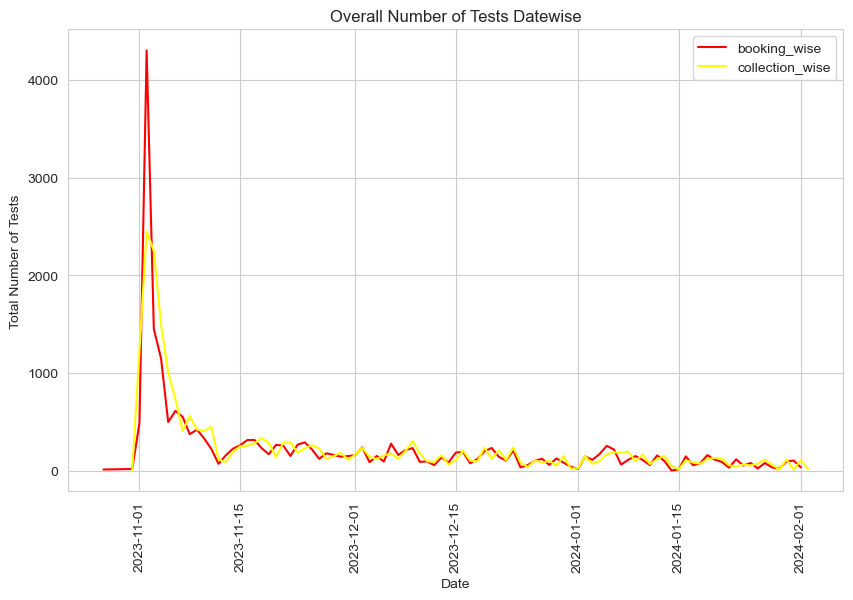


**Booking_wise**

ADF Test Results
Null Hypothesis: The series has a unit root (non-stationary)
ADF-Statistic: -2.0963840676918646
P-Value: 0.24597106979118977
Number of lags: 12
Number of observations: 82
Critical Values: {'1%': -3.512738056978279, '5%': -2.8974898650628984, '10%': -2.585948732897085}

KPSS Test Results
Null Hypothesis: The series is level or trend stationary
KPSS-Statistic: 0.6792502914188108
P-Value: 0.01543179168919902
Number of lags: 4
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

**collection_wise**

ADF Test Results
Null Hypothesis: The series has a unit root (non-stationary)
ADF-Statistic: -2.1426414544811547
P-Value: 0.2277173671979439
Number of lags: 12
Number of observations: 81
Critical Values: {'1%': -3.5137900174243235, '5%': -2.8979433868293945, '10%': -2.5861907285474777}

KPSS Test Results
Null Hypothesis: The series is level or trend stationary
KPSS-Statistic: 0.7193993377510697
P-Value: 0.011781878386266391
Number of lags

In [13]:
a = (df['booking_date'].value_counts()).sort_index()
b = (df['collection_date'].value_counts()).sort_index()
test_stat(a,b)

Both the number of tests follows almost similar trend with the booking and collection date, this signifies that most of the test are ocuured on the booking date as the collection date, which proves the efficiency of the labs, again we can see that the number of tests initially increasing rapidly , but after that the number of tests follows a decreasing a trend and decreases rapidly with time. 

Also we can see both tests tells us that the data is non-stationary, so we have to use differencing in this case.

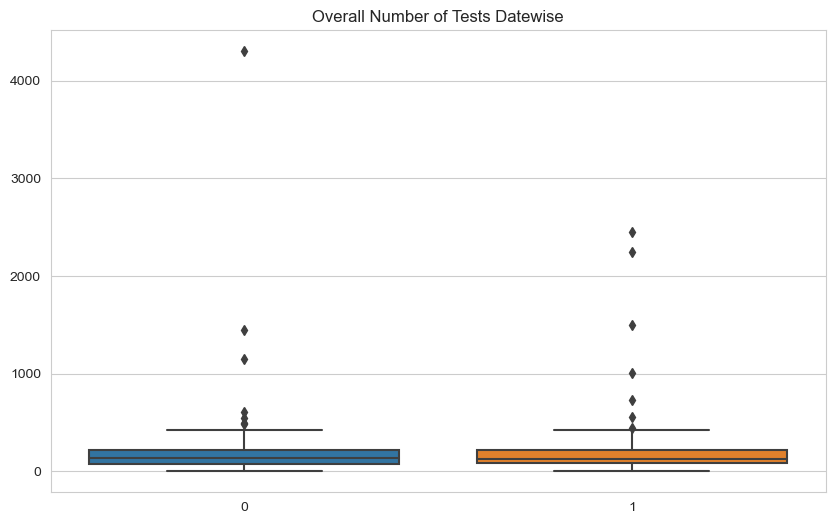

In [14]:
#lets see the outliers
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
sns.boxplot([a,b])

plt.title('Overall Number of Tests Datewise')
plt.show()


There are some high spikes in the dataset or the time series plot of the transformations but we cant remove them as it also follows the trend.

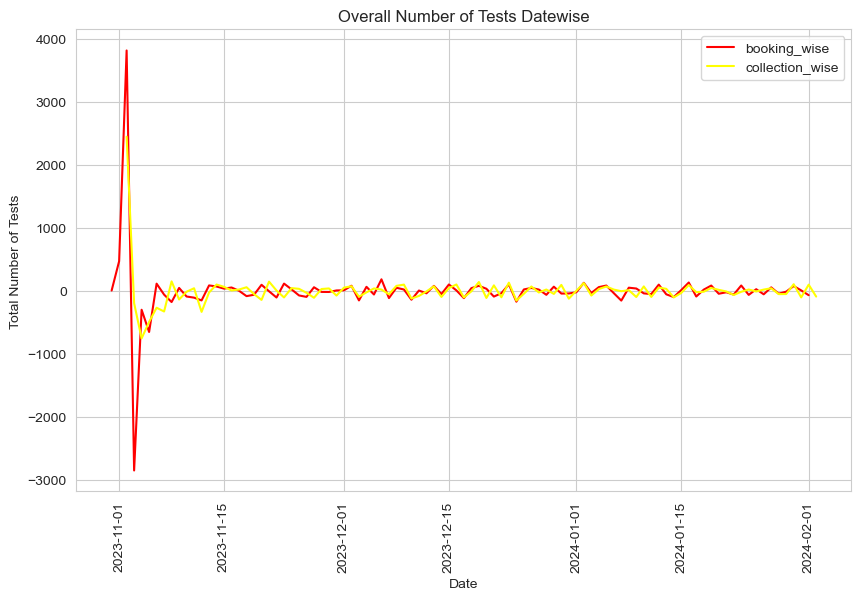


**Booking_wise**

ADF Test Results
Null Hypothesis: The series has a unit root (non-stationary)
ADF-Statistic: -5.750166465261491
P-Value: 5.992124093205175e-07
Number of lags: 11
Number of observations: 82
Critical Values: {'1%': -3.512738056978279, '5%': -2.8974898650628984, '10%': -2.585948732897085}

KPSS Test Results
Null Hypothesis: The series is level or trend stationary
KPSS-Statistic: 0.07320136514994915
P-Value: 0.1
Number of lags: 11
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

**collection_wise**

ADF Test Results
Null Hypothesis: The series has a unit root (non-stationary)
ADF-Statistic: -5.71320162194671
P-Value: 7.219754689092584e-07
Number of lags: 9
Number of observations: 83
Critical Values: {'1%': -3.5117123057187376, '5%': -2.8970475206326833, '10%': -2.5857126912469153}

KPSS Test Results
Null Hypothesis: The series is level or trend stationary
KPSS-Statistic: 0.051488578778828134
P-Value: 0.1
Number of lags: 6
Critical Values: {'10%':

In [15]:
#differencing
a_diff=(a.diff().dropna())
b_diff=(b.diff().dropna())
test_stat(a_diff,b_diff)

Both tests now tells us that the data is stationary, Now we can proceed in the finding of the AR and MA order

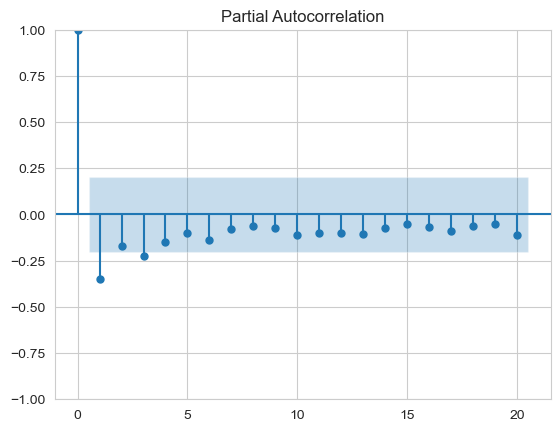

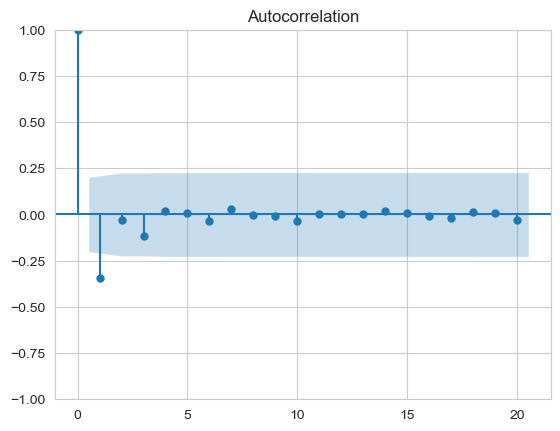

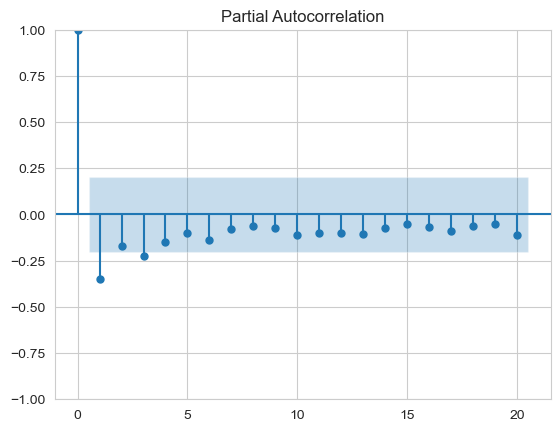

In [16]:
# use for the finding of the AR (p) and MA(q) order
plot_acf(a_diff)
plot_pacf(a_diff)

Due to the very huge initial spikes we see that in the acf and pacf plots at lag 1 we get some cut-offs crossing the 95% confidence intervals. Also most of the spikes are under 95% confidence interval that means the data is almost stationary most of them are not auto correlated directly and indirectly.

Also We can see from the graph as discussed above , we can see that seasonality of the graph is almost same with time, so we are going to use the additive seasonal decomposition.

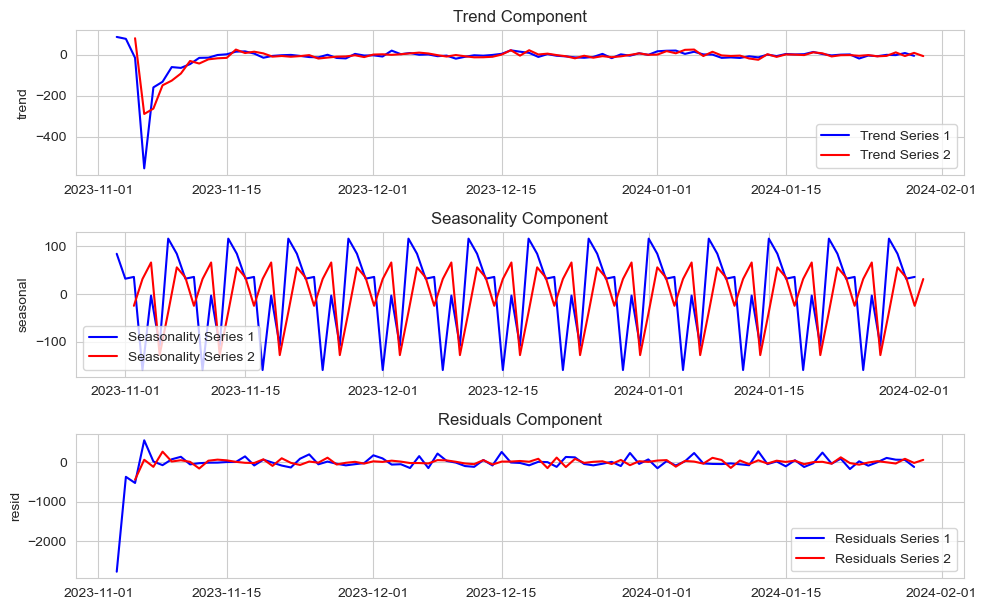

In [17]:
def plot_decomposition(series1, series2):
    # Perform seasonal decomposition for series1
    decomposition1 = seasonal_decompose(series1)
    trend1 = decomposition1.trend
    seasonal1 = decomposition1.seasonal
    residual1 = decomposition1.resid

    # Perform seasonal decomposition for series2
    decomposition2 = seasonal_decompose(series2)
    trend2 = decomposition2.trend
    seasonal2 = decomposition2.seasonal
    residual2 = decomposition2.resid

    # Plotting the decompositions for trend component
    plt.figure(figsize=(10, 8))

    # Trend
    plt.subplot(411)
    sns.lineplot(data=trend1, color='blue', label='Trend Series 1')
    sns.lineplot(data=trend2, color='red', label='Trend Series 2')
    plt.title('Trend Component')
    plt.legend(loc='best')

    # Seasonality
    plt.subplot(412)
    sns.lineplot(data=seasonal1, color='blue', label='Seasonality Series 1')
    sns.lineplot(data=seasonal2, color='red', label='Seasonality Series 2')
    plt.title('Seasonality Component')
    plt.legend(loc='best')

    # Residuals
    plt.subplot(413)
    sns.lineplot(data=residual1, color='blue', label='Residuals Series 1')
    sns.lineplot(data=residual2, color='red', label='Residuals Series 2')
    plt.title('Residuals Component')
    plt.legend(loc='best')

    plt.tight_layout()
    plt.show()

# Usage
plot_decomposition(a_diff, b_diff)

If we see the seasonality of the overall number of the customers , then we can at the initial of the week the number of the patients increasing , then it little bit decreasing and and again increasing and then decreasing again.

In [18]:
# Generally Grid searchCV and the Auto_ARIMA performing well on finding the optimal hyperparameters and fast also than using the PACF
# and ACF plots.

model = auto_arima(a_diff, start_p=0, start_q=0,
                          max_p=3, max_q=3,m=0,start_P=0,start_Q=0, 
                          max_P = 3, max_Q = 3,
                          seasonal=False,
                          d=1,D=0,trace=True,
                          error_action='ignore',   
                          suppress_warnings=True,  
                          stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1518.619, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1476.183, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1516.622, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1456.986, Time=0.11 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1455.106, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1474.183, Time=0.01 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec

Best model:

In [19]:
train=a_diff[:-10]
test=a_diff[-10:] # will use the last 10 datapoints for the testing
final_model = SARIMAX(train,order=(2,1,0),seasonal_order=(0,0,0,0))
result = final_model.fit()

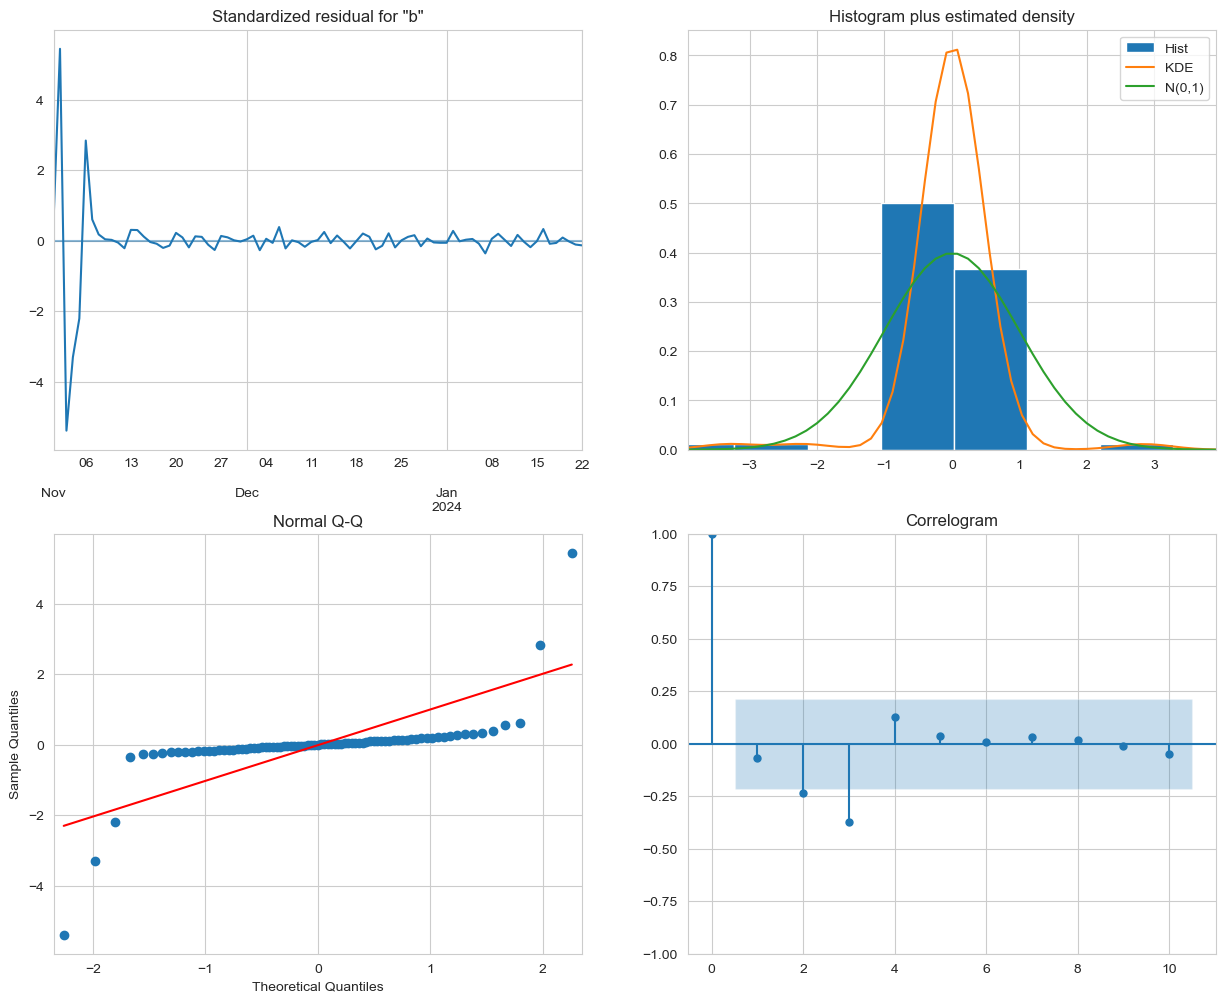

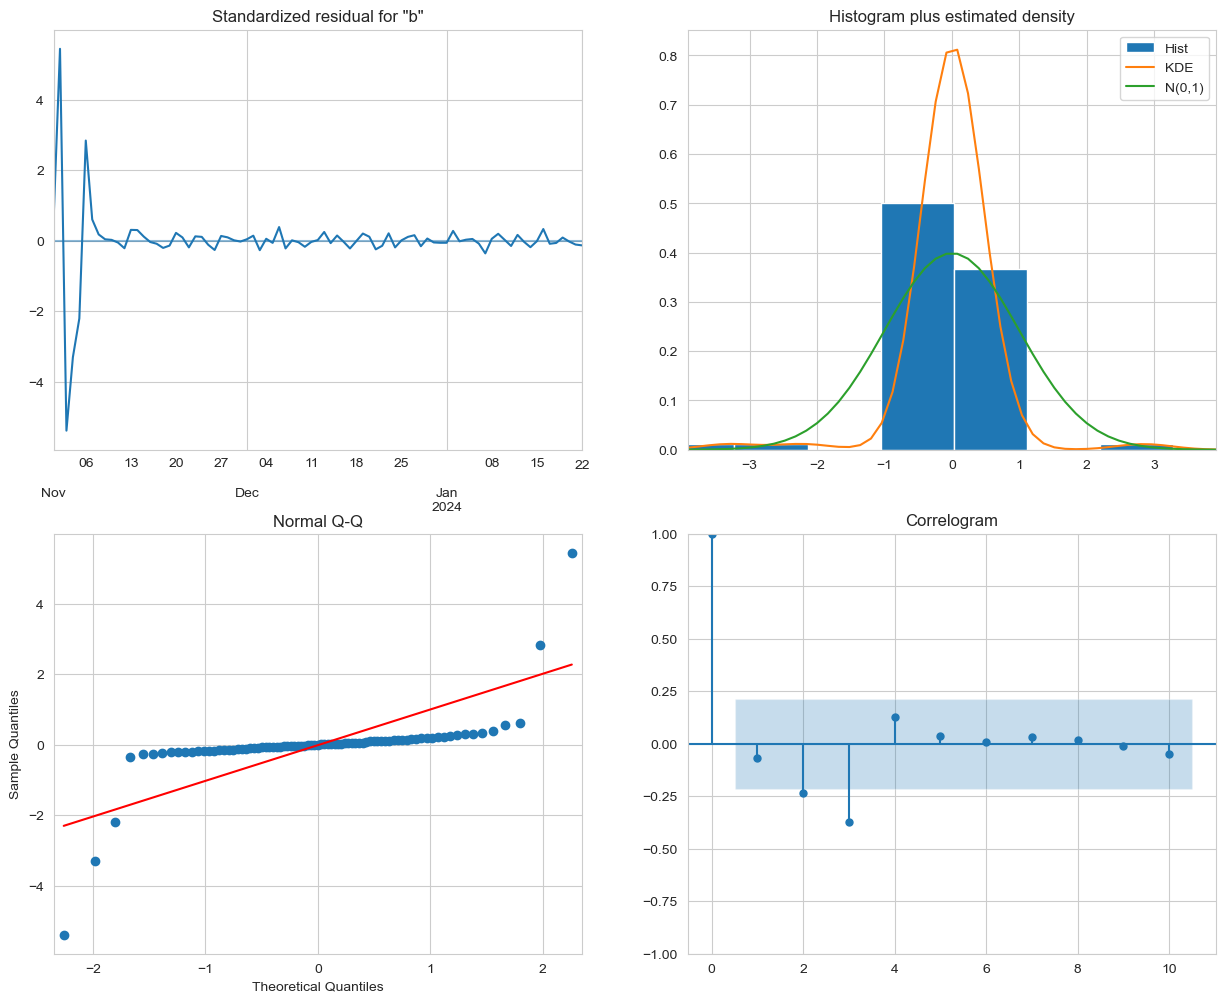

In [20]:
result.plot_diagnostics(figsize=(15,12))

We can see that the residuals are not such white noise and normally distribted, from which we can say that this is not the best model,though lets see the predictions

[Text(0.5, 0, 'Date'), Text(0, 0.5, 'Production')]

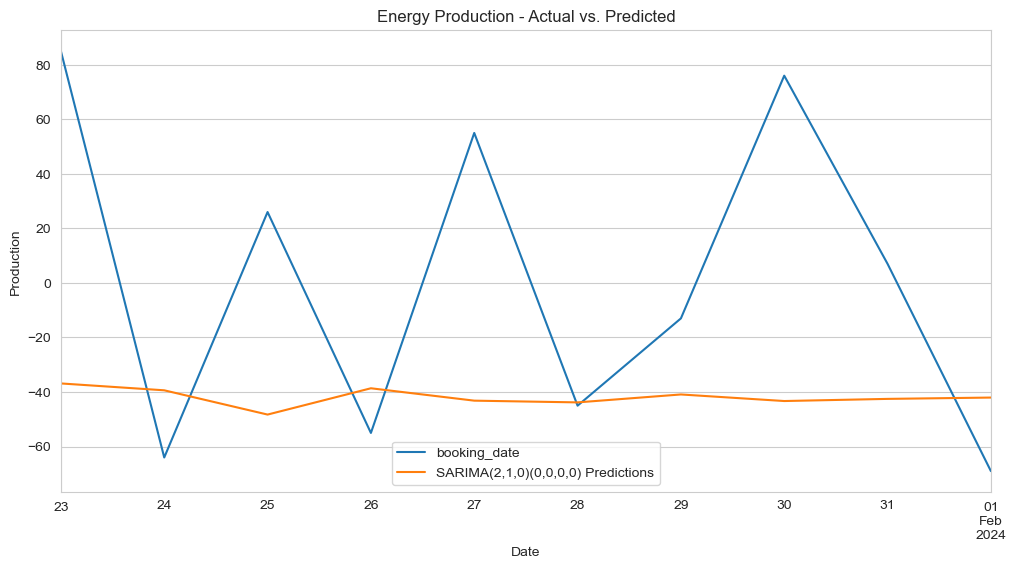

In [21]:
start=len(train)
end=len(train)+len(test)-1
predictions = result.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(2,1,0)(0,0,0,0) Predictions')
# Plot predictions against known values
title = 'Energy Production - Actual vs. Predicted'
ylabel='Production'
xlabel='Date'

ax = test.plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

We can see that the predictions made by the ARIMA is very poor and it is unable to capture the seasonability of the data. So I am now going to use the prophet model 

# Prophet

In [22]:
def run_prophet(x1,file_path):
    a_log = np.log(np.log(x1)) # log(log()) transformation for making the data stable and reduce its variance. It will make the model more robust
    data = pd.DataFrame({'ds': a_log.index, 'y': a_log.values})
    data['ds'] = data['ds'].dt.tz_localize(None)
    train = data[:-10]
    test = data[-10:]
    prophet_model = Prophet()
    prophet_model.fit(train)
    forecast = prophet_model.make_future_dataframe(periods=10)
    forecast_data = prophet_model.predict(forecast)
    prophet_model.plot(forecast_data, xlabel="Date", ylabel="Target")
    plt.show()
    forecast_data_orig = forecast_data # make sure we save the original forecast data
    forecast_data_orig['yhat'] = (np.exp(np.exp(forecast_data_orig['yhat'])))
    forecast_data_orig['yhat_lower'] = (np.exp(np.exp(forecast_data_orig['yhat_lower'])))
    forecast_data_orig['yhat_upper'] = ((np.exp(np.exp(forecast_data_orig['yhat_upper']))))

    forecast_trace = go.Scatter(x=forecast_data_orig['ds'], y=forecast_data_orig['yhat'], mode='lines', name='Forecast', line=dict(color='blue'))
    lower_bound_trace = go.Scatter(x=forecast_data_orig['ds'], y=forecast_data_orig['yhat_lower'], mode='lines', name='Lower Bound', line=dict(color='green'))
    upper_bound_trace = go.Scatter(x=forecast_data_orig['ds'], y=forecast_data_orig['yhat_upper'], mode='lines', name='Upper Bound', line=dict(color='red'))
    actual_trace = go.Scatter(x=x1.index, y=x1.values, mode='lines', name='Actual', line=dict(color='yellow'))
    fig = go.Figure()
    fig.add_trace(forecast_trace)
    fig.add_trace(lower_bound_trace)
    fig.add_trace(upper_bound_trace)
    fig.add_trace(actual_trace)
    fig.update_layout(title='Original Forecast Data',
                  xaxis_title='Date',
                  yaxis_title='Forecasted Values',
                  xaxis_tickangle=45,
                  legend=dict(x=0, y=1),
                  )
    fig.show()
    print('MAE :',mean_absolute_error(x1[-10:],forecast_data_orig['yhat'][-10:]))
    with open(file_path, 'wb') as file:
        pickle.dump(prophet_model, file)

In [23]:
def run_prophet2(x1,file_path):
    a_log = (np.log(x1)) #log() transformation
    data = pd.DataFrame({'ds': a_log.index, 'y': a_log.values})
    data['ds'] = data['ds'].dt.tz_localize(None)
    train = data[:-10]
    test = data[-10:]
    prophet_model = Prophet()
    prophet_model.fit(train)
    forecast = prophet_model.make_future_dataframe(periods=10)
    forecast_data = prophet_model.predict(forecast)
    prophet_model.plot(forecast_data, xlabel="Date", ylabel="Target")
    plt.show()
    forecast_data_orig = forecast_data # make sure we save the original forecast data
    forecast_data_orig['yhat'] = ((np.exp(forecast_data_orig['yhat'])))
    forecast_data_orig['yhat_lower'] = ((np.exp(forecast_data_orig['yhat_lower'])))
    forecast_data_orig['yhat_upper'] = (((np.exp(forecast_data_orig['yhat_upper']))))

    forecast_trace = go.Scatter(x=forecast_data_orig['ds'], y=forecast_data_orig['yhat'], mode='lines', name='Forecast', line=dict(color='blue'))
    lower_bound_trace = go.Scatter(x=forecast_data_orig['ds'], y=forecast_data_orig['yhat_lower'], mode='lines', name='Lower Bound', line=dict(color='green'))
    upper_bound_trace = go.Scatter(x=forecast_data_orig['ds'], y=forecast_data_orig['yhat_upper'], mode='lines', name='Upper Bound', line=dict(color='red'))
    actual_trace = go.Scatter(x=x1.index, y=x1.values, mode='lines', name='Actual', line=dict(color='yellow'))
    fig = go.Figure()
    fig.add_trace(forecast_trace)
    fig.add_trace(lower_bound_trace)
    fig.add_trace(upper_bound_trace)
    fig.add_trace(actual_trace)
    fig.update_layout(title='Original Forecast Data',
                  xaxis_title='Date',
                  yaxis_title='Forecasted Values',
                  xaxis_tickangle=45,
                  legend=dict(x=0, y=1),
                  )
    fig.show()
    print('MAE :',mean_absolute_error(x1[-10:],forecast_data_orig['yhat'][-10:]))
    with open(file_path, 'wb') as file:
        pickle.dump(prophet_model, file)

In [24]:
def run_prophet3(x1,file_path):
    a_log,lamb = stats.boxcox(x1)# box-cox transformation
    data = pd.DataFrame({'ds': x1.index, 'y': a_log})
    data['ds'] = data['ds'].dt.tz_localize(None)
    train = data[:-10]
    test = data[-10:]
    prophet_model = Prophet()
    prophet_model.fit(train)
    forecast = prophet_model.make_future_dataframe(periods=10)
    forecast_data = prophet_model.predict(forecast)
    prophet_model.plot(forecast_data, xlabel="Date", ylabel="Target")
    plt.show()
    forecast_data_orig = forecast_data # make sure we save the original forecast data
    forecast_data_orig['yhat'] = special.inv_boxcox(forecast_data_orig['yhat'],lamb)
    forecast_data_orig['yhat_lower'] = special.inv_boxcox(forecast_data_orig['yhat_lower'],lamb)
    forecast_data_orig['yhat_upper'] = special.inv_boxcox(forecast_data_orig['yhat_upper'],lamb)

    forecast_trace = go.Scatter(x=forecast_data_orig['ds'], y=forecast_data_orig['yhat'], mode='lines', name='Forecast', line=dict(color='blue'))
    lower_bound_trace = go.Scatter(x=forecast_data_orig['ds'], y=forecast_data_orig['yhat_lower'], mode='lines', name='Lower Bound', line=dict(color='green'))
    upper_bound_trace = go.Scatter(x=forecast_data_orig['ds'], y=forecast_data_orig['yhat_upper'], mode='lines', name='Upper Bound', line=dict(color='red'))
    actual_trace = go.Scatter(x=x1.index, y=x1.values, mode='lines', name='Actual', line=dict(color='yellow'))
    fig = go.Figure()
    fig.add_trace(forecast_trace)
    fig.add_trace(lower_bound_trace)
    fig.add_trace(upper_bound_trace)
    fig.add_trace(actual_trace)
    fig.update_layout(title='Original Forecast Data',
                  xaxis_title='Date',
                  yaxis_title='Forecasted Values',
                  xaxis_tickangle=45,
                  legend=dict(x=0, y=1),
                  )
    fig.show()
    print('MAE :',mean_absolute_error(x1[-10:],forecast_data_orig['yhat'][-10:]))
    with open(file_path, 'wb') as file:
        pickle.dump(prophet_model, file)

16:23:18 - cmdstanpy - INFO - Chain [1] start processing
16:23:19 - cmdstanpy - INFO - Chain [1] done processing


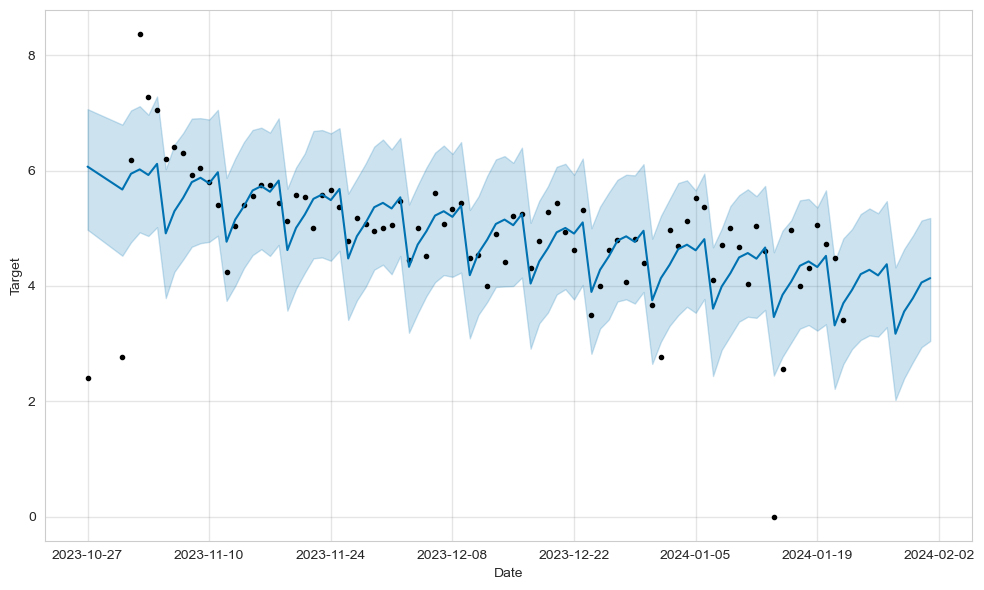

MAE : 27.95120456097252


In [25]:
run_prophet2(a,'model_overall.pkl')

# Test Category Wise Analysis

In [26]:
(df['test_code'].isna()).sum()

12

In [27]:
df['test_code']=df['test_code'].dropna()

In [28]:
# top 5 test category
df['prefix_test_code']=df['test_code'].str[:2]
x=(((df['test_code'].str[:2]).value_counts()).head(5)).index
df1=df[df['prefix_test_code'].isin(x)]
a1=(df1[df1['prefix_test_code']=='BC']['booking_date'].value_counts()).sort_index()
a2=(df1[df1['prefix_test_code']=='HM']['booking_date'].value_counts()).sort_index()
a3=(df1[df1['prefix_test_code']=='SE']['booking_date'].value_counts()).sort_index()
a4=(df1[df1['prefix_test_code']=='PL']['booking_date'].value_counts()).sort_index()
a5=(df1[df1['prefix_test_code']=='CP']['booking_date'].value_counts()).sort_index()

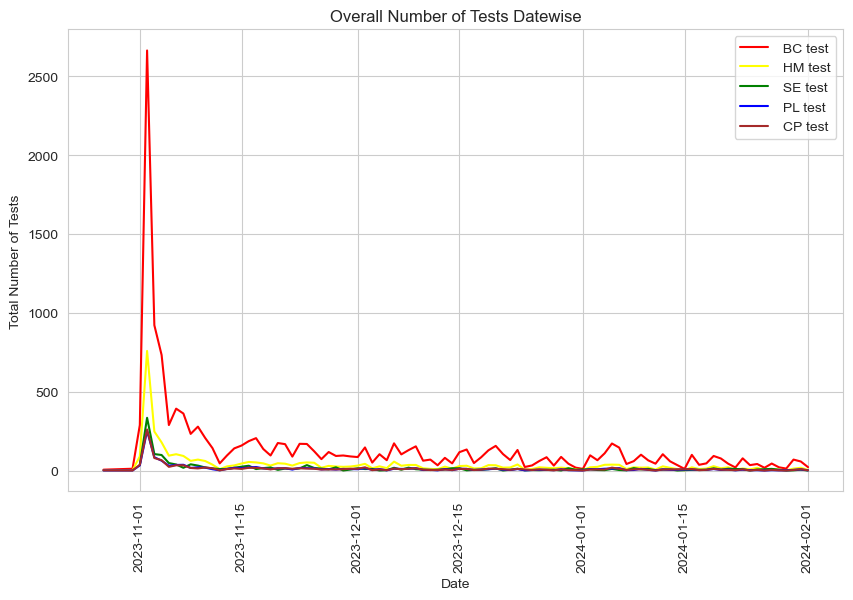

In [29]:
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
sns.lineplot(x=a1.index,y=a1.values,color='red',label=' BC test')
sns.lineplot(x=a2.index,y=a2.values,color='yellow',label=' HM test')
sns.lineplot(x=a3.index,y=a3.values,color='green',label=' SE test')
sns.lineplot(x=a4.index,y=a4.values,color='blue',label=' PL test')
sns.lineplot(x=a5.index,y=a5.values,color='brown',label=' CP test')
plt.title('Overall Number of Tests Datewise')
plt.xlabel('Date')
plt.ylabel('Total Number of Tests')
plt.xticks(rotation=90)
plt.show()

The distributions of all the category wise tests are almost same with overall test in terms of trend and seasonality, we are going to use the prophet model for the predictions,before this also use the log and boxcox transformations for making the data stable, and then on the basis of the MAE we will select the final model for all the  6 categories

16:23:20 - cmdstanpy - INFO - Chain [1] start processing
16:23:20 - cmdstanpy - INFO - Chain [1] done processing


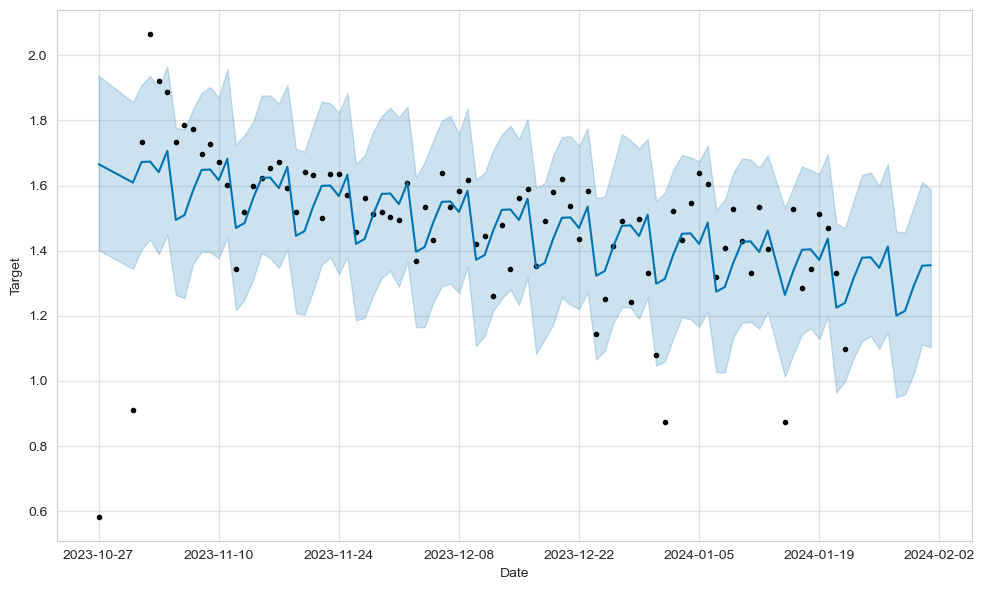

MAE : 20.133108735754654


In [30]:
run_prophet(a1,'model_BC.pkl')

16:23:21 - cmdstanpy - INFO - Chain [1] start processing
16:23:21 - cmdstanpy - INFO - Chain [1] done processing


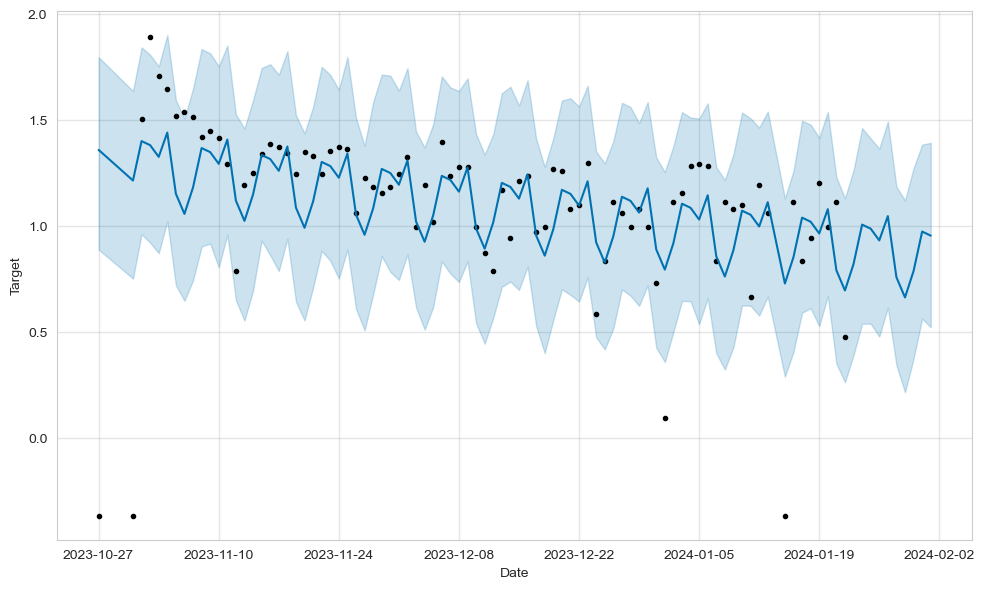

MAE : 5.669469290131149


In [31]:
run_prophet(a2,'model_HM.pkl')

16:23:21 - cmdstanpy - INFO - Chain [1] start processing
16:23:22 - cmdstanpy - INFO - Chain [1] done processing


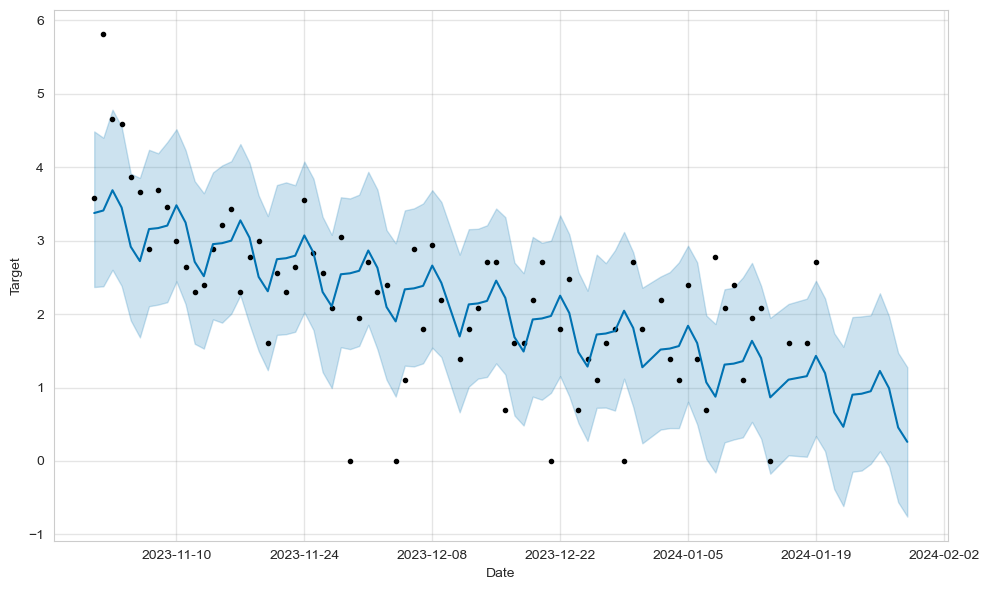

MAE : 4.2365194131646975


In [32]:
run_prophet2(a3,'model_SE.pkl')

16:23:22 - cmdstanpy - INFO - Chain [1] start processing
16:23:22 - cmdstanpy - INFO - Chain [1] done processing


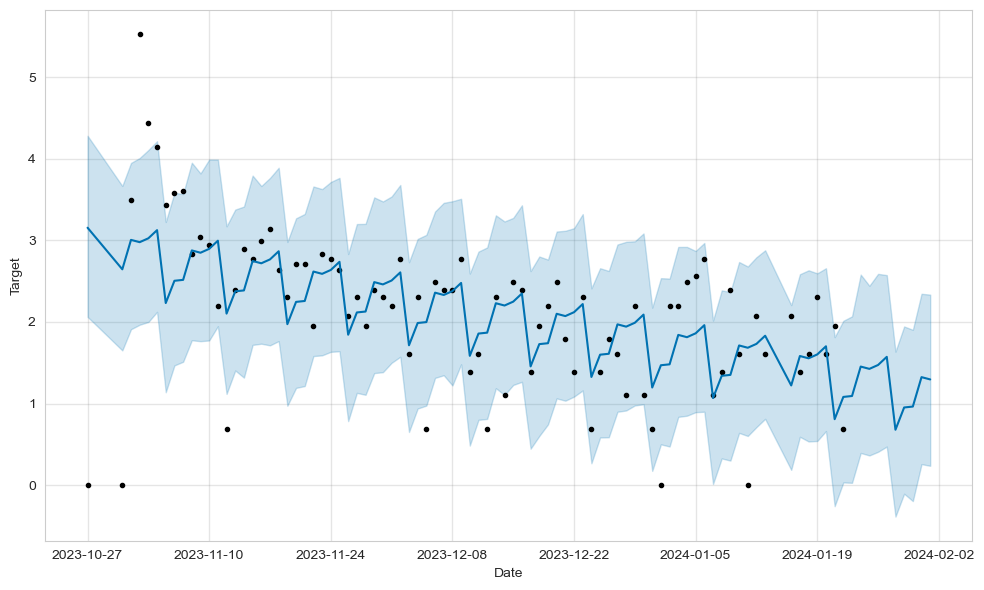

MAE : 1.9529022814653385


In [33]:
run_prophet2(a4,'model_PL.pkl')

16:23:23 - cmdstanpy - INFO - Chain [1] start processing
16:23:23 - cmdstanpy - INFO - Chain [1] done processing


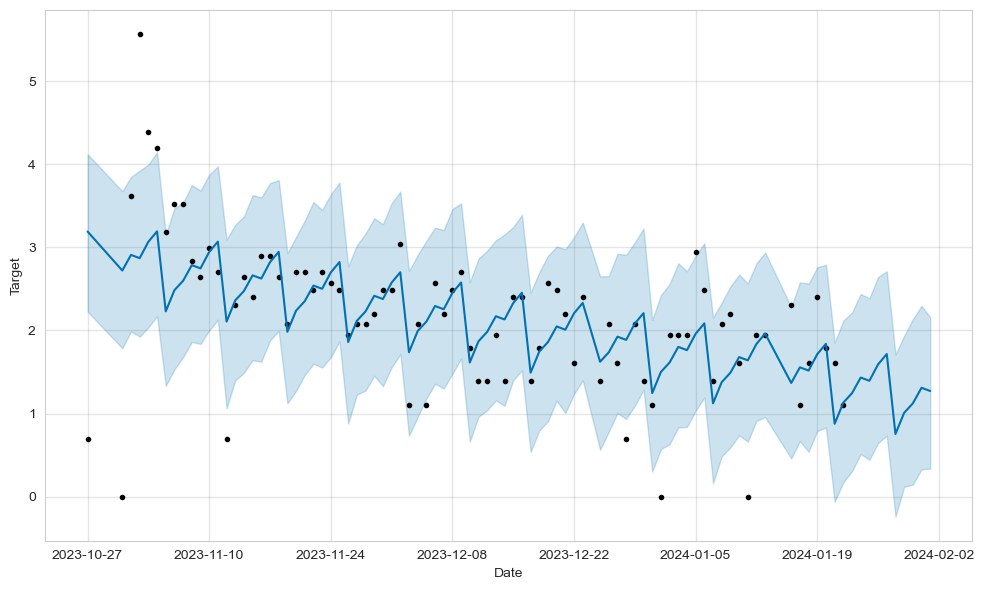

MAE : 2.2811158925261297


In [34]:
run_prophet2(a5,'model_CP.pkl')

16:23:23 - cmdstanpy - INFO - Chain [1] start processing
16:23:24 - cmdstanpy - INFO - Chain [1] done processing


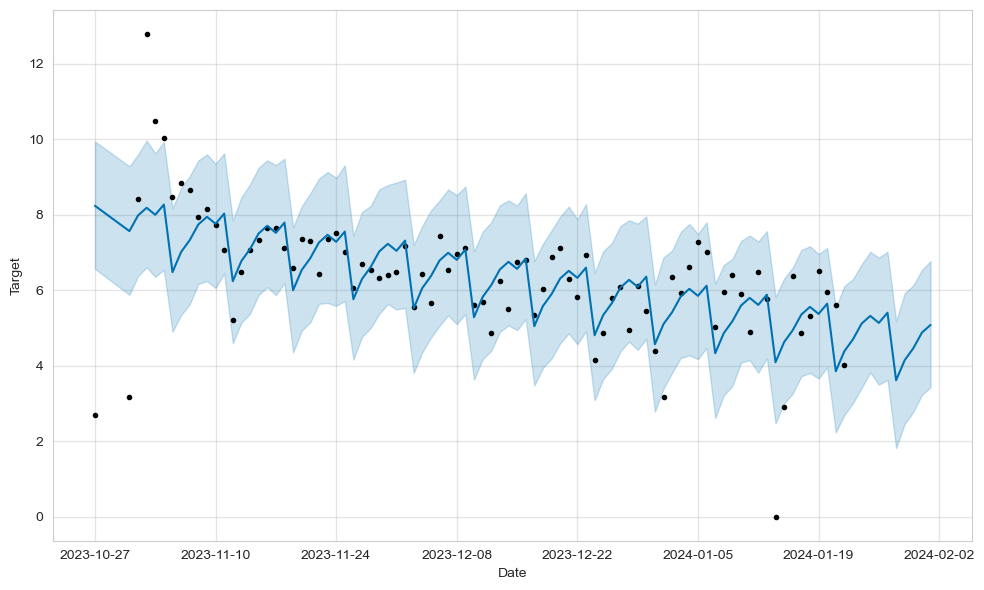

MAE : 28.216602285631048


In [35]:
run_prophet3(a,'model_overall_2.pkl')

16:23:24 - cmdstanpy - INFO - Chain [1] start processing
16:23:24 - cmdstanpy - INFO - Chain [1] done processing


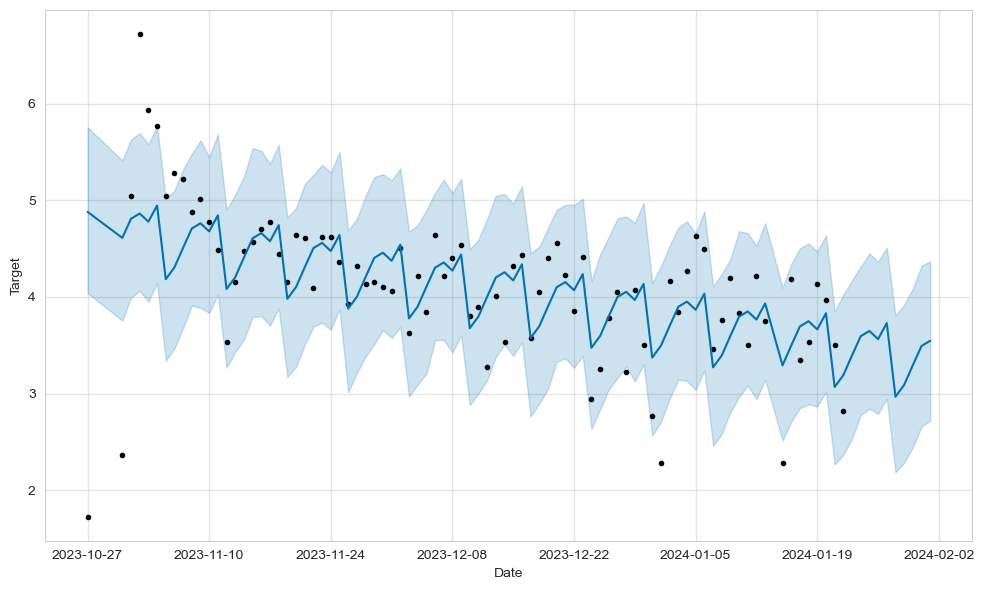

MAE : 19.686651593538944


In [36]:
run_prophet3(a1,'model_BC_2.pkl')

16:23:25 - cmdstanpy - INFO - Chain [1] start processing
16:23:25 - cmdstanpy - INFO - Chain [1] done processing


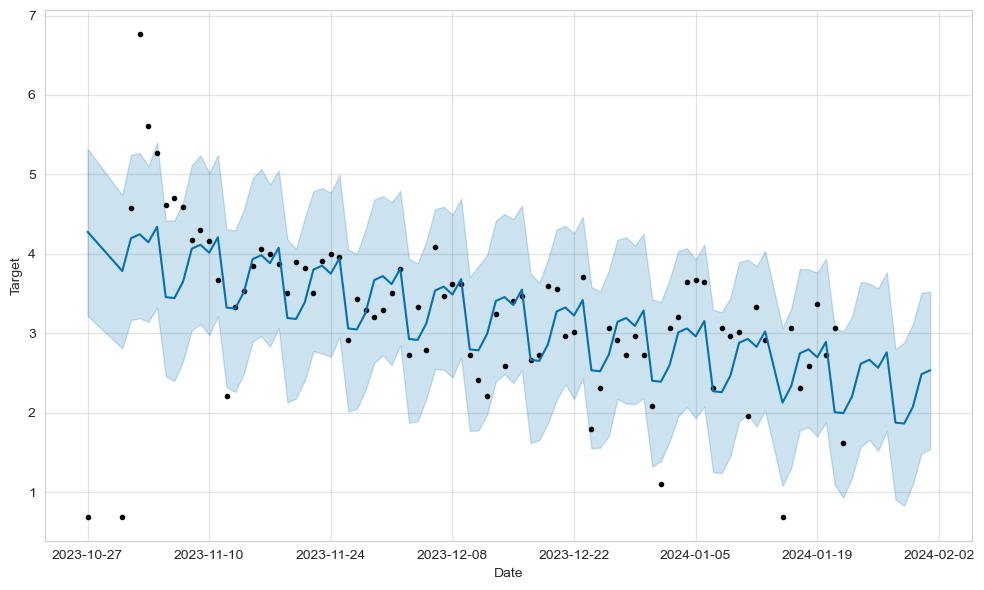

MAE : 5.422681961855786


In [37]:
run_prophet3(a2,'model_HM_2.pkl')

16:23:26 - cmdstanpy - INFO - Chain [1] start processing
16:23:26 - cmdstanpy - INFO - Chain [1] done processing


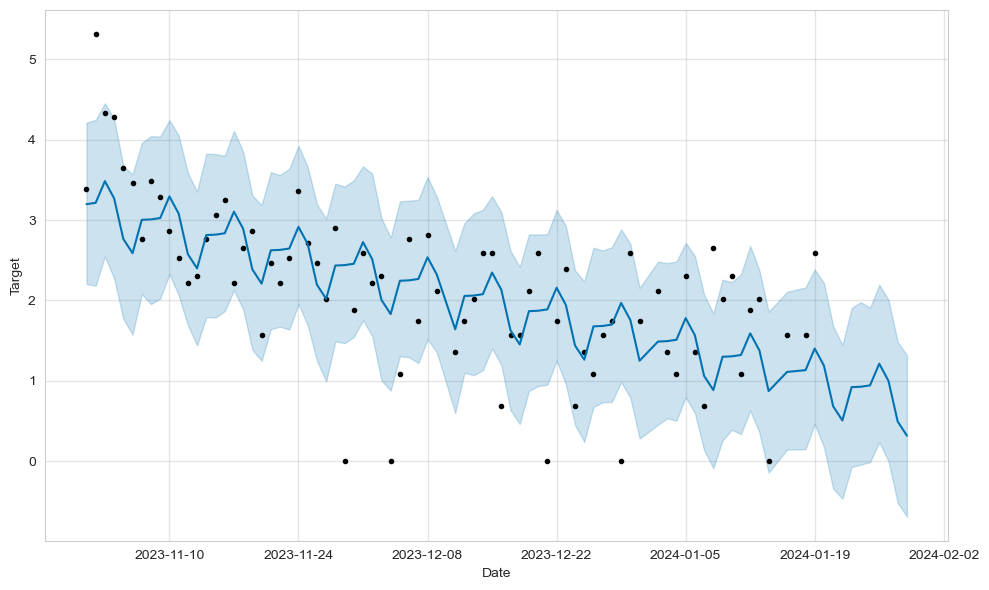

MAE : 4.229731539568073


In [38]:
run_prophet3(a3,'model_SE_2.pkl')

16:23:26 - cmdstanpy - INFO - Chain [1] start processing
16:23:26 - cmdstanpy - INFO - Chain [1] done processing


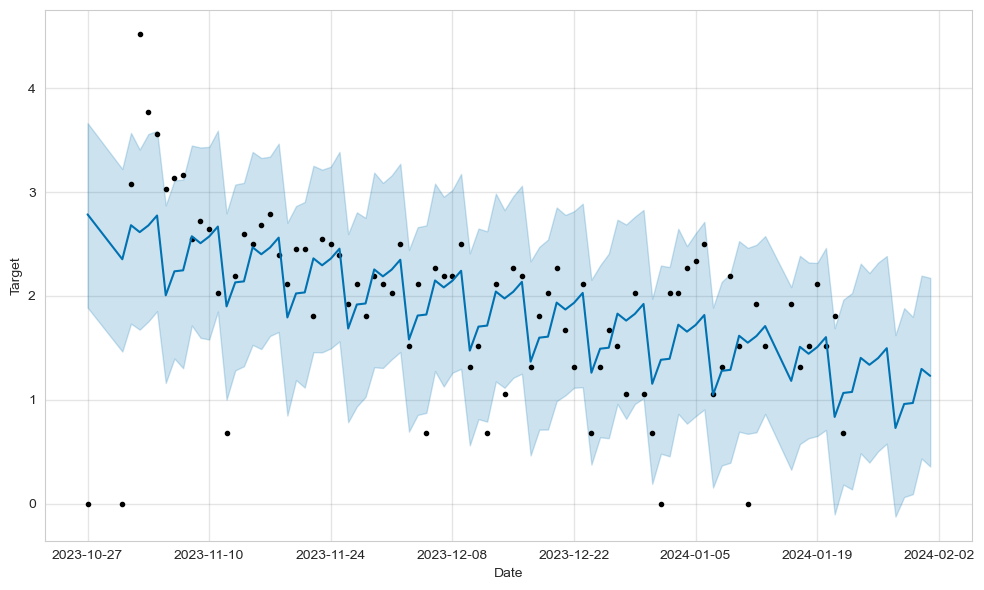

MAE : 1.9529796129927466


In [39]:
run_prophet3(a4,'model_SE_2.pkl')

16:23:27 - cmdstanpy - INFO - Chain [1] start processing
16:23:27 - cmdstanpy - INFO - Chain [1] done processing


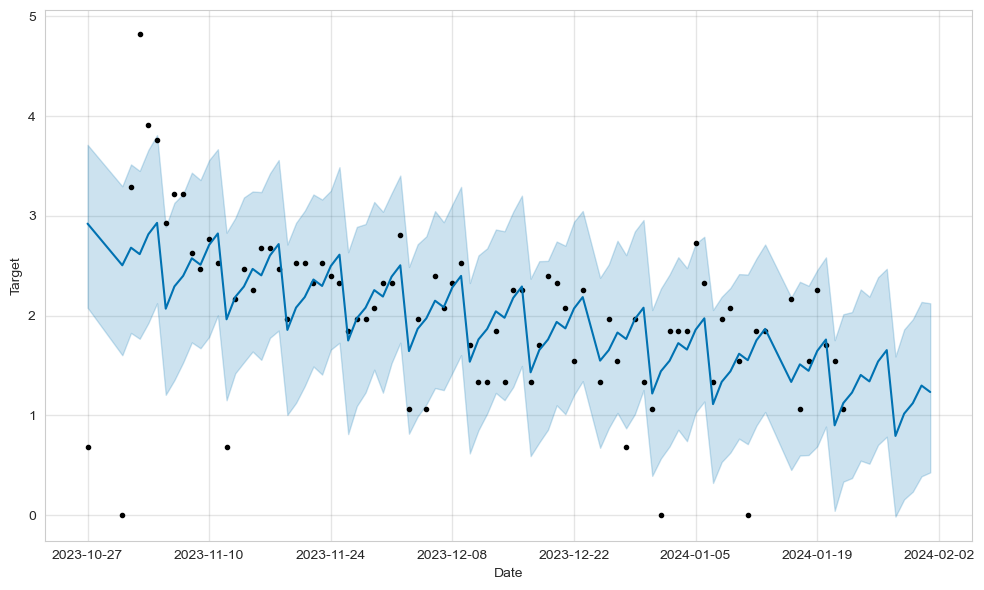

MAE : 2.30166282914592


In [40]:
run_prophet3(a5,'model_CP_2.pkl')

In [41]:
data = {
    'log_transform_MAE': [27.95, 20.13, 5.669, 4.23, 1.95, 2.28],
    'box_cox_transform_MAE': [28.21, 19.68, 5.42, 4.229, 1.952, 2.301]
}
index = ['overall', 'BC', 'HM', 'SE', 'PL', 'CP']
result = pd.DataFrame(data, index=index)
result

log_transform_MAE  box_cox_transform_MAE
overall             27.950                 28.210
BC                  20.130                 19.680
HM                   5.669                  5.420
SE                   4.230                  4.229
PL                   1.950                  1.952
CP                   2.280                  2.301

# Results & Discussions

1. **Prophet performs better than the ARIMA as due to its robust seasonality, trend, holiday, error components which is fare better than a simple ARIMA.**

2. **The transformations are very important as prophet is unable to capture the high variance of the data , so we have to make the data stable and less random , log and boxcox transformations are most famous transfprmations, in this case. For some category the MAE are almost same, it is due to the lambda parameter which estimated on the basis of the maximum likelihood, if the lambda =0 , we get the lambda parameter.**

3. **Due to the lack of sufficient amount of data, the models become unable to capture all the patterns of the data, if more data is added then , model will be imporoved better**

In [42]:
#pip install nbconvert 

In [43]:
#pip install pandoc